In [140]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import norm,skew
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import ElasticNet,Lasso
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
import xgboost as xgb
import lightgbm as lgb

In [141]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [142]:
df_train.info()
print("----------------------------")
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [143]:
#Save the 'Id' column
train_ID = df_train['Id']
test_ID = df_test['Id']

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
df_train.drop("Id", axis = 1, inplace = True)
df_test.drop("Id", axis = 1, inplace = True)

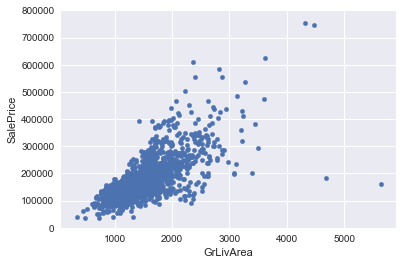

In [144]:
# scatter plot between living area square feet and saleprice
data = pd.concat([df_train['SalePrice'], df_train['GrLivArea']], axis=1)
data.plot.scatter(x='GrLivArea', y='SalePrice', ylim=(0,800000));

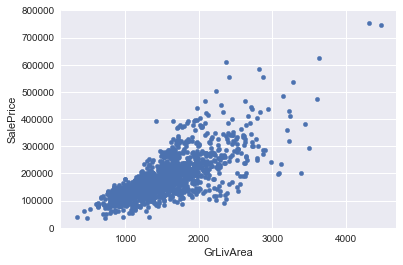

In [145]:
#Deleting outliers
df_train = df_train.drop(df_train[(df_train['GrLivArea']>4000) & (df_train['SalePrice']<300000)].index)

data = pd.concat([df_train['SalePrice'], df_train['GrLivArea']], axis=1)
data.plot.scatter(x='GrLivArea', y='SalePrice', ylim=(0,800000));

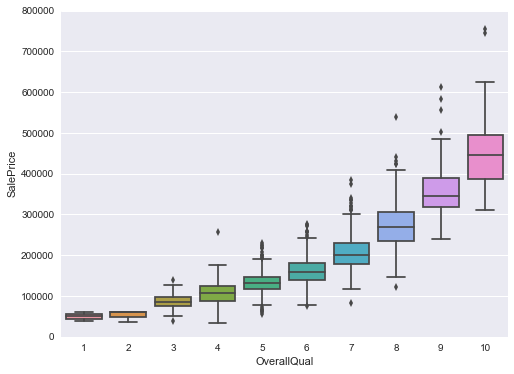

In [146]:
# box plot between Overall material and finish quality and saleprice
data = pd.concat([df_train['SalePrice'], df_train['OverallQual']], axis=1)
# for figure size (magnifies)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='OverallQual', y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

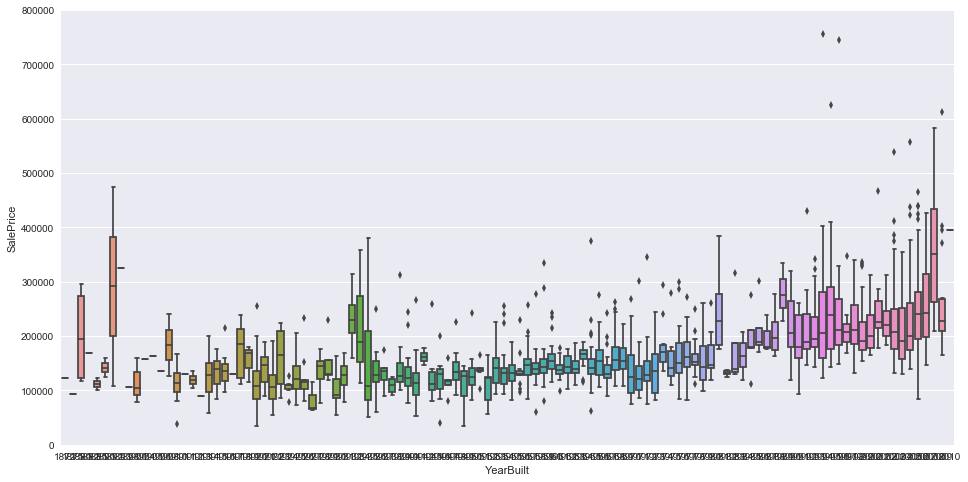

In [147]:
# box plot between year built and saleprice
data = pd.concat([df_train['SalePrice'], df_train['YearBuilt']], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x='YearBuilt', y='SalePrice', data=data)
fig.axis(ymin=0, ymax=800000);

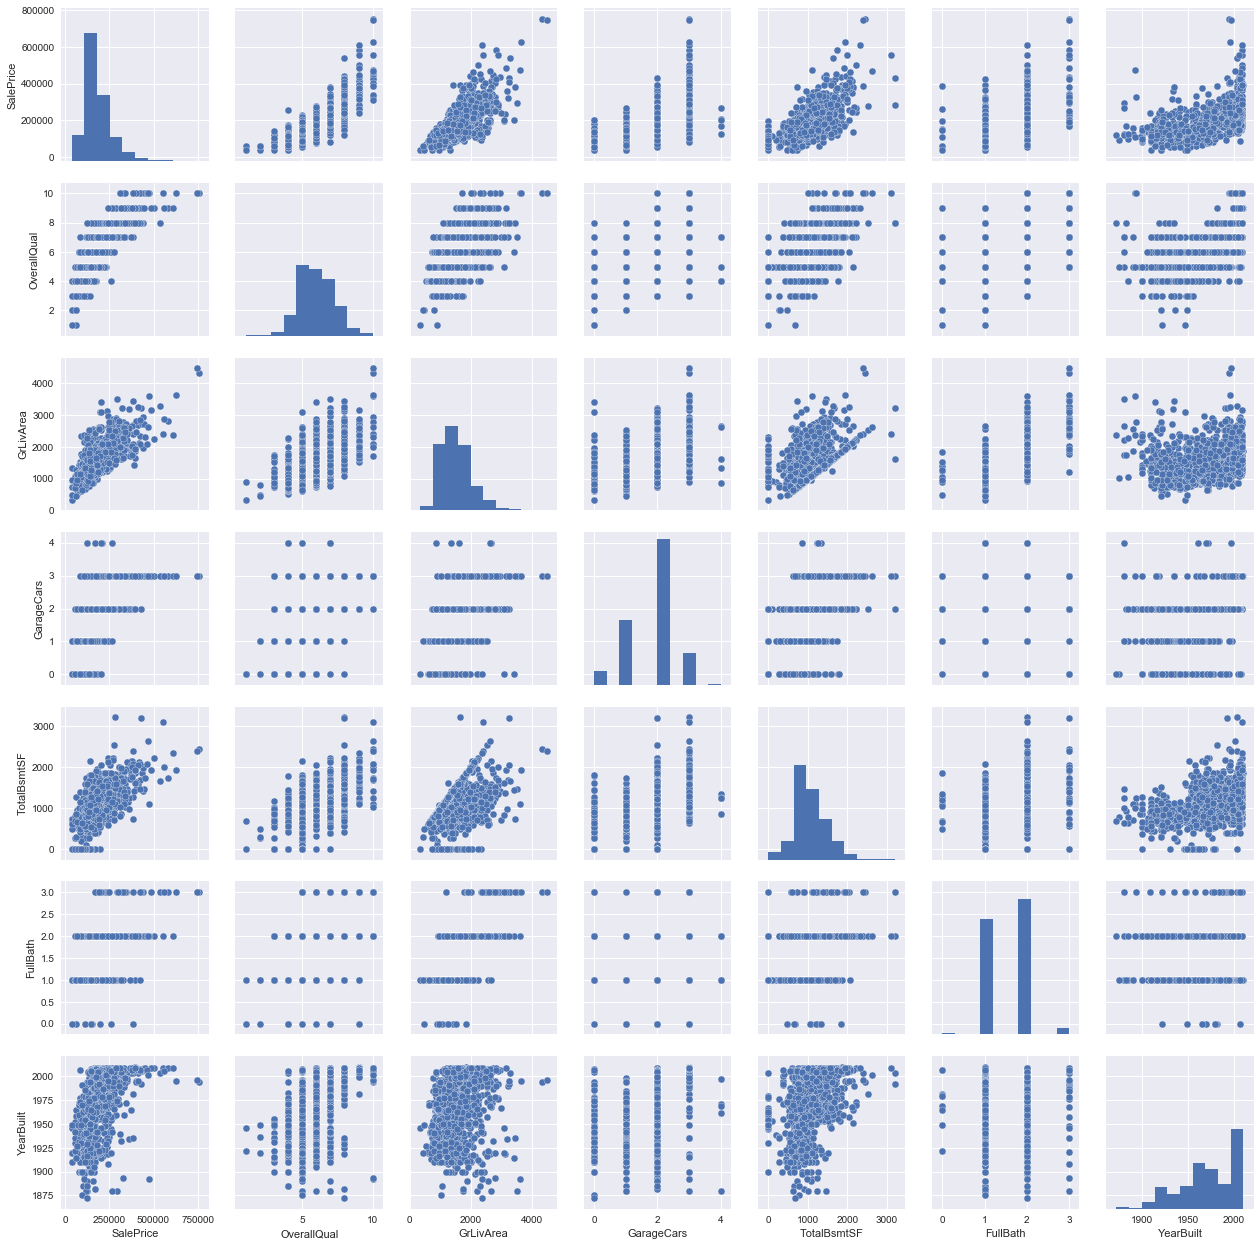

In [148]:
#scatterplot
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(df_train[cols], size = 2.5)
plt.show();

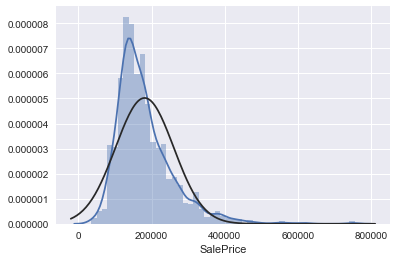

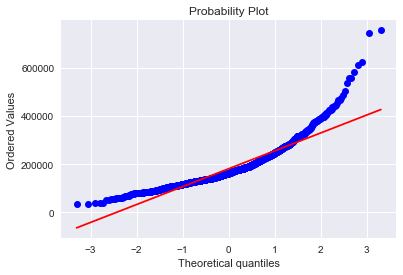

In [149]:
#histogram and normal probability plot
sns.distplot(df_train['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)

In [150]:
#applying log transformation
df_train['SalePrice'] = np.log1p(df_train['SalePrice'])

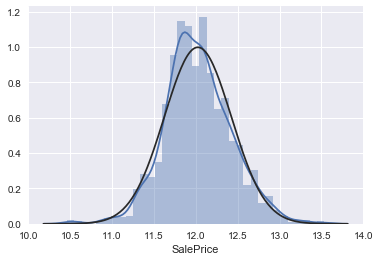

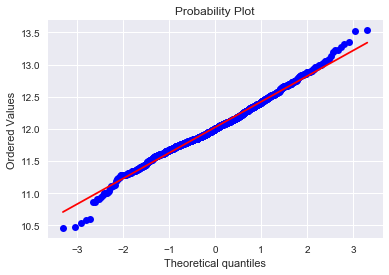

In [151]:
#transformed histogram and normal probability plot
sns.distplot(df_train['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)

In [152]:
# concatenate the train and test data in the same dataframe
ntrain = df_train.shape[0]
ntest = df_test.shape[0]
y_train = df_train["SalePrice"]
all_data = pd.concat((df_train, df_test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
all_data.shape

(2917, 79)

In [153]:
#missing data
all_data_na = ((all_data.isnull().sum() / len(all_data)) * 100).sort_values(ascending=False)
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

,Missing Ratio
PoolQC,99.691464
MiscFeature,96.400411
Alley,93.212204
Fence,80.425094
FireplaceQu,48.680151
LotFrontage,16.660953
GarageFinish,5.450806
GarageQual,5.450806
GarageYrBlt,5.450806
GarageCond,5.450806


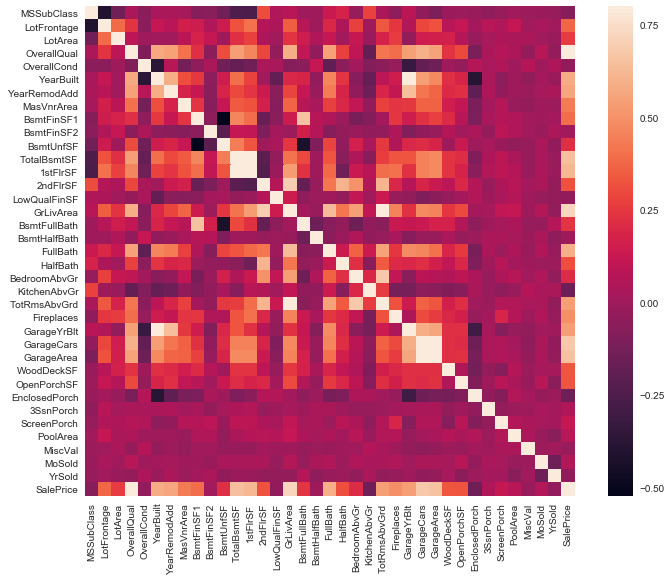

In [154]:
#correlation matrix
corrmat = df_train.corr()
f, ax = plt.subplots(figsize=(12, 9))
# vmax are Values to anchor the colormap
sns.heatmap(corrmat, vmax=.8, square=True);

In [155]:
# there are two red colored squares. The first one refers to the 'TotalBsmtSF' and '1stFlrSF' variables, and the second one
# refers to the 'GarageX' variables. Both cases show how significant the correlation is between these variables. They give
# almost the same information so multicollinearity really occurs. 

In [156]:
# from above missing ratio

# missing ratio is so much so
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")
all_data["Alley"] = all_data["Alley"].fillna("None")
all_data["Fence"] = all_data["Fence"].fillna("None")
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")

# area of each street connected to the house property most likely have a similar area to other houses in its neighborhood ,
# we can fill in missing values by the median LotFrontage of the neighborhood.
#Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

# GarageType, GarageFinish, GarageQual and GarageCond : Replacing missing data with None
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')

# GarageYrBlt, GarageArea and GarageCars : Replacing missing data with 0 (Since No garage = no cars in such garage.)
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)

# BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath : missing values are likely zero for having
# no basement
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

# BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1 and BsmtFinType2 : For all these categorical basement-related features, NaN 
# means that there is no basement.
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

# MasVnrArea and MasVnrType : NA most likely means no masonry veneer for these houses. We can fill 0 for the area and None for
# the type.                                         
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

# MSZoning (The general zoning classification) : 'RL' is by far the most common value. So we can fill in missing values with 'RL'
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

# Utilities : For this categorical feature all records are "AllPub", except for one "NoSeWa" and 2 NA 
all_data = all_data.drop(['Utilities'], axis=1)

# Functional : data description says NA means typical
all_data["Functional"] = all_data["Functional"].fillna("Typ")

# Electrical : It has one NA value. Since this feature has mostly 'SBrkr', we can set that for the missing value.
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

# KitchenQual: Only one NA value, and same as Electrical, we set 'TA' (which is the most frequent) for the missing value in
# KitchenQual.
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])

# Exterior1st and Exterior2nd : Again Both Exterior 1 & 2 have only one missing value. We will just substitute in the most
# common string
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])

# SaleType : Fill in again with most frequent which is "WD"
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

# MSSubClass : Na most likely means No building class. We can replace missing values with None
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")



In [157]:
# Transforming some numerical variables that are really categorical
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)
all_data['OverallCond'] = all_data['OverallCond'].astype(str)
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

In [158]:
# Label Encoding some categorical variables
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
for c in cols:
    lbl = LabelEncoder() 
    all_data[c]=lbl.fit_transform(all_data[c])

In [159]:
# Since area related features are very important to determine house prices, we add one more feature which is the total area of
# basement, first and second floor areas of each house
# Adding total sqfootage feature 
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

In [160]:
#convert categorical variable into dummy
all_data = pd.get_dummies(all_data)
all_data.shape

(2917, 220)

In [161]:
df_train = all_data[:ntrain]
df_test = all_data[ntrain:]

In [162]:
lr = LinearRegression()
lr.fit(df_train, y_train)
y_pred = np.expm1(lr.predict(df_test))
lr.score(df_train, y_train)

C:\anaconda\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in expm1
  This is separate from the ipykernel package so we can avoid doing imports until


0.9422463639043317

In [163]:
dr=DecisionTreeRegressor(random_state=0)
dr.fit(df_train, y_train)
y_pred = np.expm1(dr.predict(df_test))
dr.score(df_train, y_train)

0.99999999468234857

In [164]:
rf = RandomForestRegressor(n_estimators=100,random_state=0)
rf.fit(df_train, y_train)
y_pred = np.expm1(rf.predict(df_test))
rf.score(df_train, y_train)

0.98363583670239652

In [165]:
# This model may be very sensitive to outliers. So we need to made it more robust on them. For that we use the sklearn's
# Robustscaler() method on pipeline
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
lasso.fit(df_train, y_train)
y_pred = np.expm1(lasso.predict(df_test))
lasso.score(df_train, y_train)

0.9347718809117056

In [166]:
# made robust to outliers
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
ENet.fit(df_train, y_train)
y_pred = np.expm1(ENet.predict(df_test))
ENet.score(df_train, y_train)

0.93528297654104786

In [167]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
KRR.fit(df_train, y_train)
y_pred = np.expm1(KRR.predict(df_test))
KRR.score(df_train, y_train)

C:\anaconda\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 2.3276962168264275e-17
  ' condition number: {}'.format(rcond), RuntimeWarning)


0.99910324249761151

In [168]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,max_depth=4, max_features='sqrt',min_samples_leaf=15,
                                   min_samples_split=10, loss='huber', random_state =5)
GBoost.fit(df_train, y_train)
y_pred = np.expm1(GBoost.predict(df_test))
GBoost.score(df_train, y_train)

0.98308411995922529

In [169]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, learning_rate=0.05, max_depth=3,min_child_weight=1.7817,
                             n_estimators=2200,reg_alpha=0.4640, reg_lambda=0.8571,subsample=0.5213, silent=1,nthread = -1)
model_xgb.fit(df_train, y_train)
y_pred = np.expm1(model_xgb.predict(df_test))
model_xgb.score(df_train, y_train)

0.96126225235104812

In [170]:
# LightGBM 
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,learning_rate=0.05, n_estimators=720,max_bin = 55,
                              bagging_fraction = 0.8,bagging_freq = 5, feature_fraction = 0.2319,feature_fraction_seed=9,
                              bagging_seed=9,min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
model_lgb.fit(df_train, y_train)
y_pred = np.expm1(model_lgb.predict(df_test))
model_lgb.score(df_train, y_train)

0.96710247228697876

In [171]:
submission = pd.DataFrame({
        "Id": test_ID,
        "SalePrice": y_pred
    })
submission.to_csv('housing_prediction.csv', index=False)